In [1]:
import pathlib
import numpy as np

from fytok.Tokamak import Tokamak

from spdm.view import View as sp_view

input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-12-07 16:11:14,103 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-07T16:11:13.712866.
 Job ID: fytok_salmon_surface_11650

###################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            {"code": {"name": "fusion_reaction"}},
            # {"code": {"name": "collisional_equipartition"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "control_parameters": {
                    "bvp_rms_mask": [0.96],
                    "hyper_diff": 0.0001,
                    "max_nodes": 512,
                    "verbose": 2,
                },
            },
        },
        "primary_coordinate": {"index": (index := 0), "label": r"\bar{rho}_{tor_norm}"},
        "equations": [
            # fmt: off
            {"identifier": "ion/D/density",             "boundary_condition": [2, 1]},
            {"identifier": "ion/T/density",             "boundary_condition": [2, 1]},
            # {"identifier": "ion/He/density",            "boundary_condition": [2, 1]},
            {"identifier": "ion/alpha/density",         "boundary_condition": [4, 4]},

            # {"identifier": "ion/D/temperature",         "boundary_condition": [2, 1]},
            # {"identifier": "ion/T/temperature",         "boundary_condition": [2, 1]},
            # {"identifier": "ion/He/temperature",        "boundary_condition": [2, 1]},

            {"identifier": "electrons/temperature",     "boundary_condition": [2, 1]},
            # fmt: on
        ],
    },
)

2023-12-07 16:11:14,506 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2023-12-07 16:11:14,765 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-12-07 16:11:14,831 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.transport_solver.refresh(
    time=0.0,
    initial_value=[1.0e19, 1.0e19, 0.10e19, 0.10e19,1000, 1000, 1000, 1000],
    boundary_value=[
        [[0.0], [2.0e19]],   #   D 
        [[0.0], [2.0e19]],   #   T 
        # [[0.0], [0.5e18]],   #   He
        [[0.0], [0.0]],      #   alpha

        # [[0.0], [1000]],     #   D
        # [[0.0], [1000]],     #   T
        # [[0.0], [1000]],     #   He
        [[0.0], [1000]],     #   electron
    ],
)

2023-12-07 16:11:14,882 [    spdm]     INFO: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-12-07 16:11:15,472 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2023-12-07 16:11:15,489 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-07 16:11:15,496 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-07 16:11:15,512 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-07 16:11:15,519 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-07 16:11:15,535 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2023-12-07 16:11:15,543 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2023-12-07 16:11:15,559 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2023-12-07 16:11:15,567 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2023-12-07 16:11:15,581 [    spdm]     INFO: Initialize module fytok.plugins.transport_solv

2023-12-07 16:11:18,620 [    spdm]     INFO: Load module spdm.view.view_matplotlib


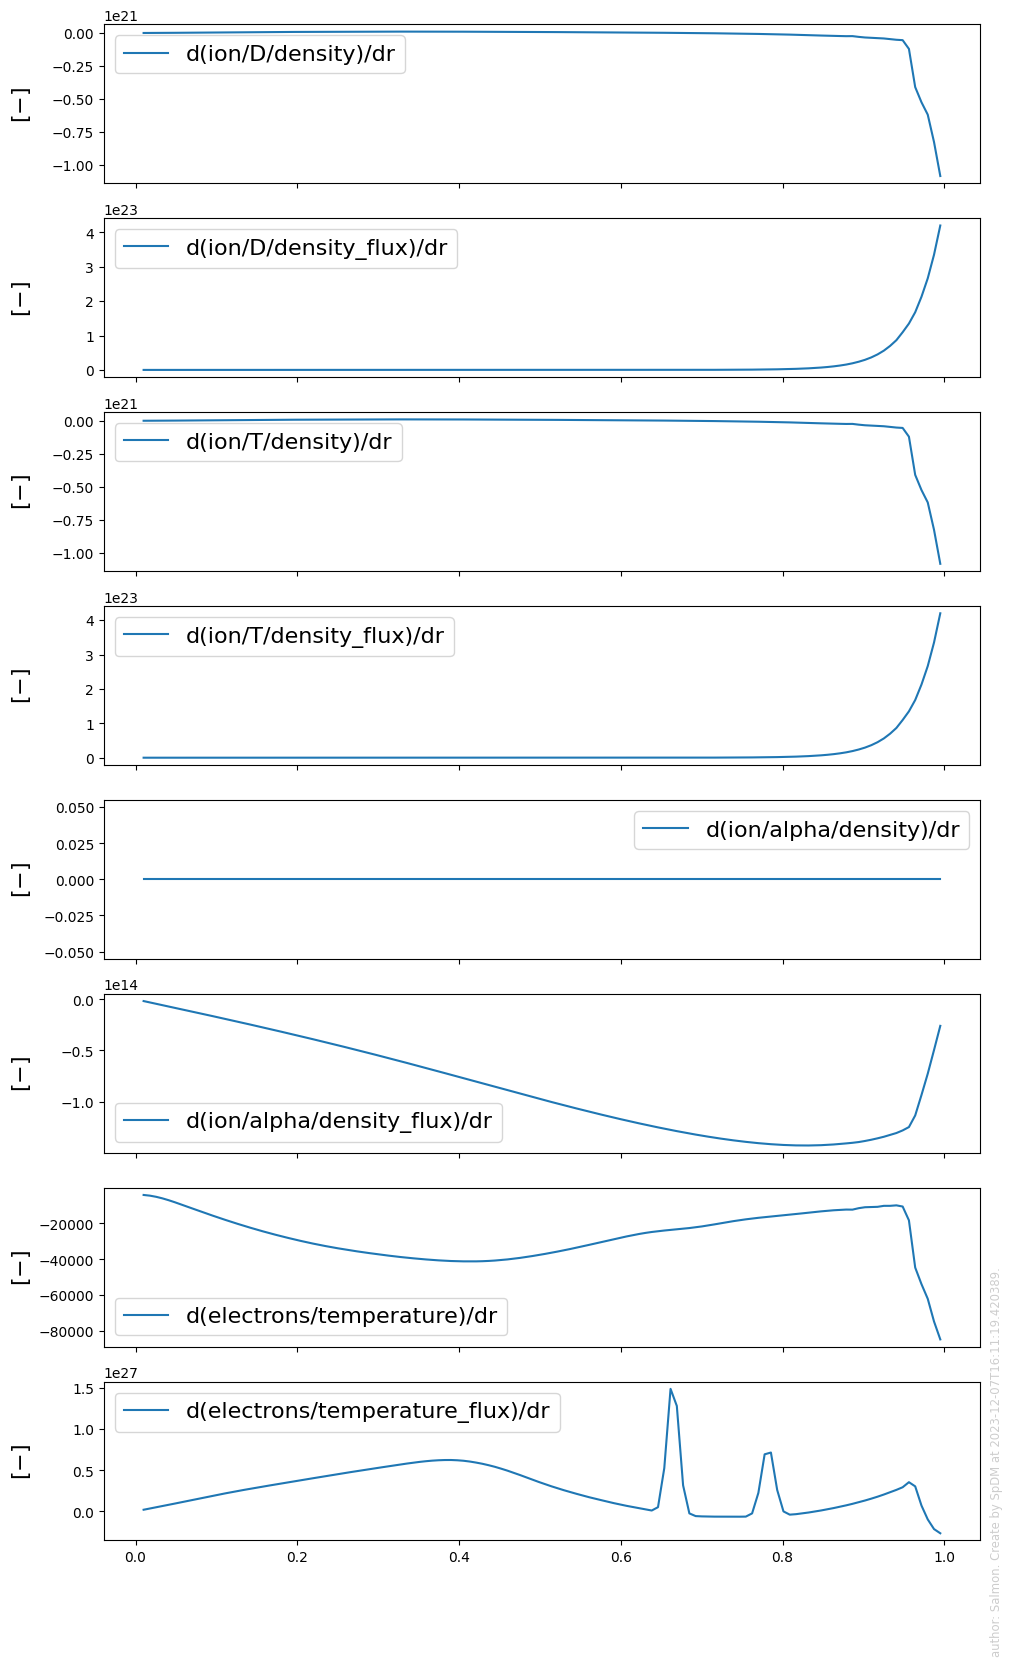

In [4]:
solver_1d = tokamak.transport_solver.time_slice.current
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                (equ.primary_quantity.d_dr, f"d({equ.primary_quantity.identifier})/dr"),
                (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
)

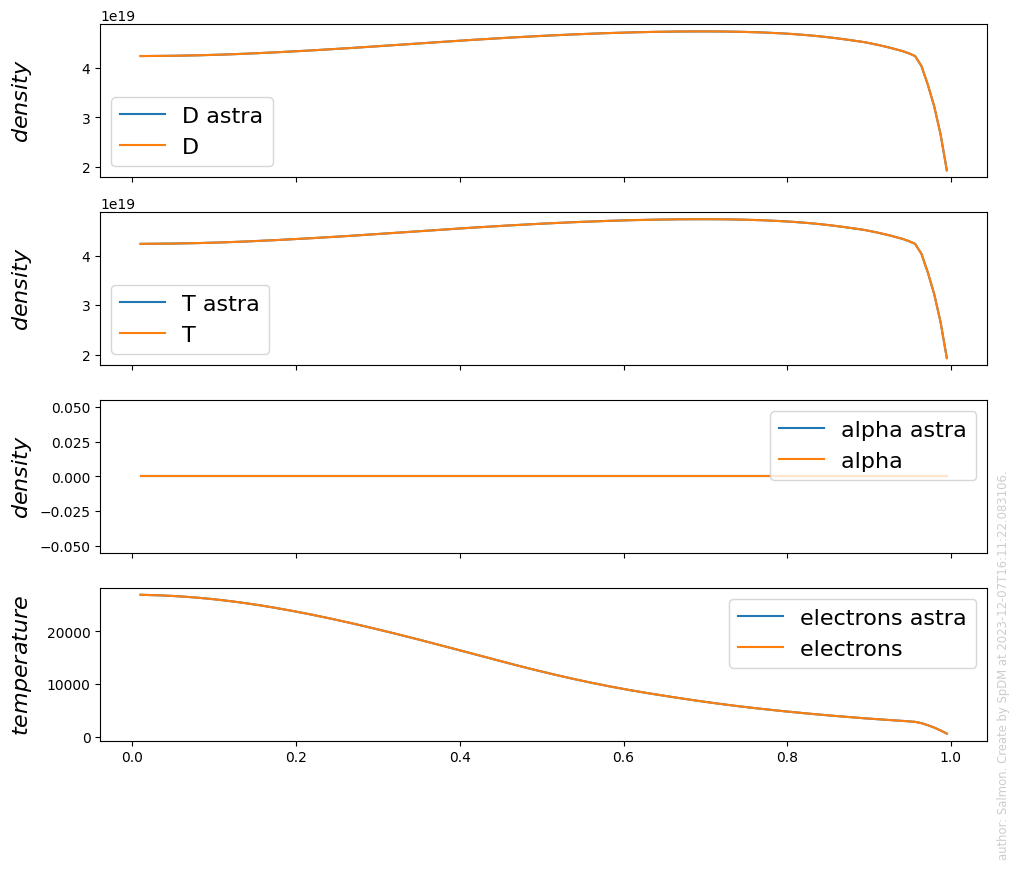

In [5]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *[
        (
            [
                (
                    core_profiles_1d.get(equ.primary_quantity.identifier,0),
                    rf"{equ.primary_quantity.identifier.split('/')[-2]} astra",
                ),
                (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier.split('/')[-2]} "),
            ],
            {"y_label": equ.primary_quantity.identifier.split("/")[-1]},
        )
        for equ in solver_1d.equation
    ],
)

2023-12-07 16:11:23,160 [    spdm]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=0] failed! y_label= "None"  [cannot unpack non-iterable NoneType object] 
2023-12-07 16:11:23,161 [    spdm]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=1] failed! y_label= "None"  [cannot unpack non-iterable NoneType object] 
2023-12-07 16:11:23,162 [    spdm]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=2] failed! y_label= "None"  [cannot unpack non-iterable NoneType object] 


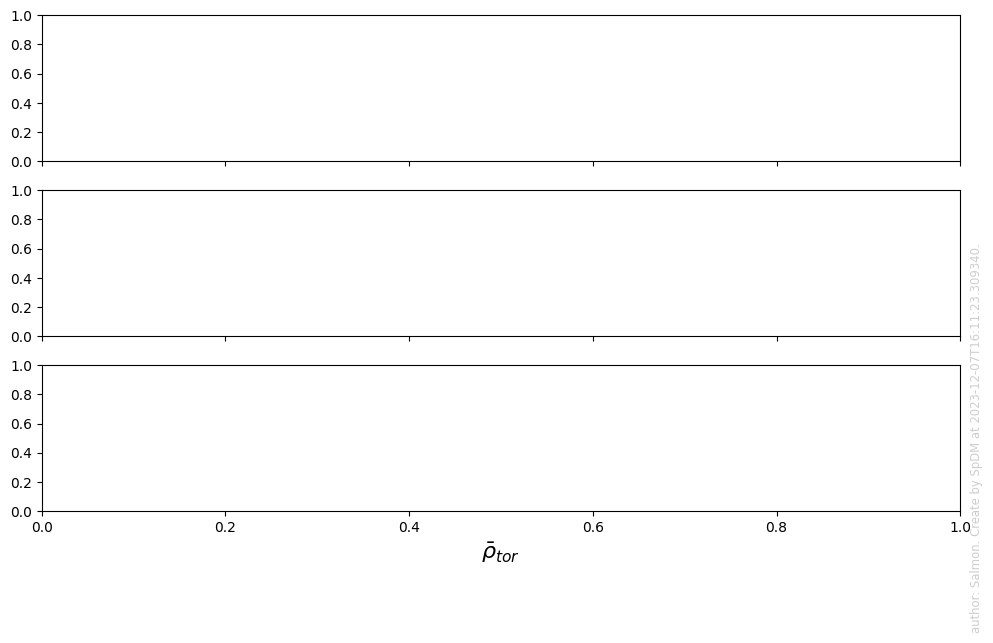

In [6]:
s = 0
core_transport_1d = tokamak.core_transport.model[1].time_slice.current.profiles_1d

fig = sp_view.plot(
    core_transport_1d.grid_d.rho_tor_norm,
    # (core_sources_1d.electrons.energy, r"$Q_e$"),
    # (core_transport_1d.ion[2].energy.d, r"$\chi_e$"),
    # (core_transport_1d.ion[2].energy.v, r"$V^{pinch}_{Te}$"),
    # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
    # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
    (core_transport_1d.ion[s].particles.d, rf"$D_{core_transport_1d.ion[2].label}$"),
    (core_transport_1d.ion[s].particles.v, rf"$V_{core_transport_1d.ion[2].label}$"),
 
    x_label=r"$\bar{\rho}_{tor}$",
)

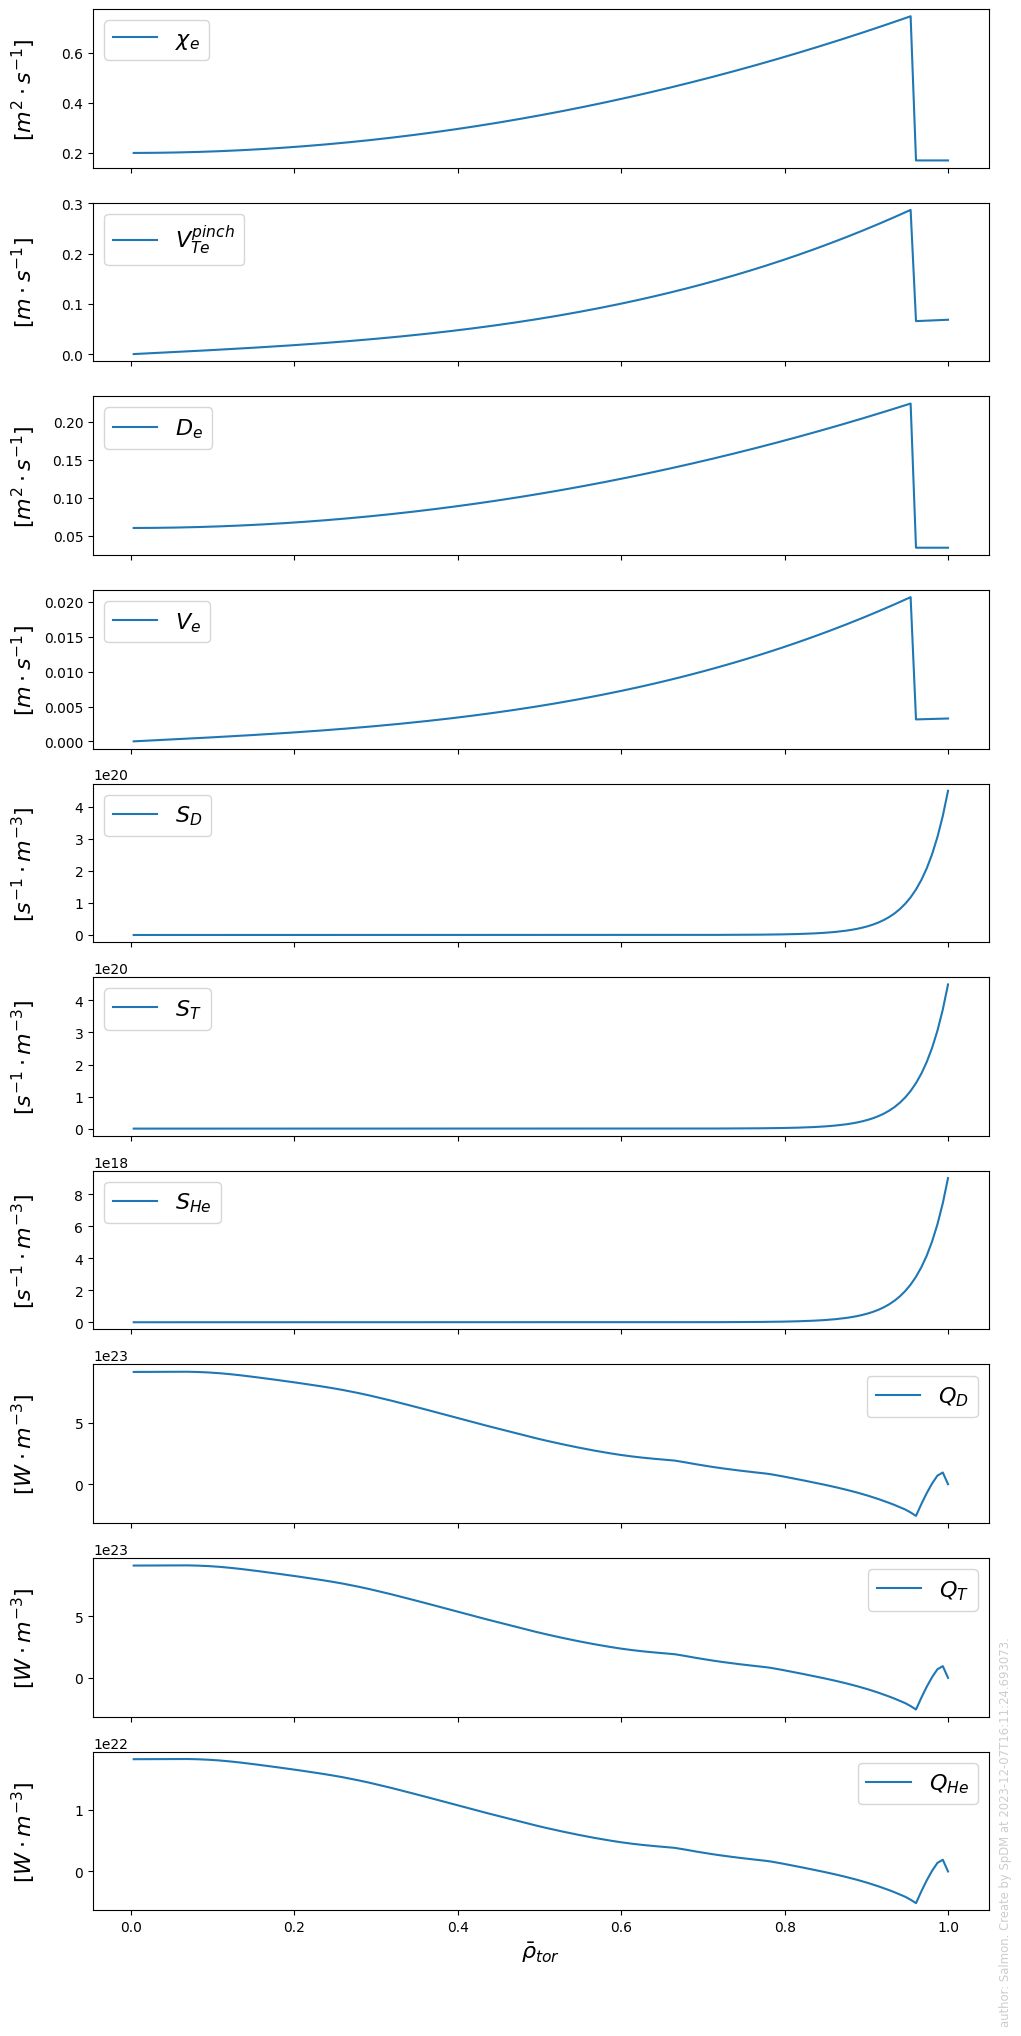

In [7]:
s = 0
core_sources_1d = tokamak.core_sources.source[s].time_slice.current.profiles_1d
core_transport_1d = tokamak.core_transport.model[s].time_slice.current.profiles_1d

fig = sp_view.plot(
    core_sources_1d.grid.rho_tor_norm,
    # (core_sources_1d.electrons.energy, r"$Q_e$"),
    (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
    (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
    # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
    # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
    (core_transport_1d.electrons.particles.d, r"$D_e$"),
    (core_transport_1d.electrons.particles.v, r"$V_e$"),
    *[(ion.particles, rf"$S_{{{ion.label}}}$") for ion in core_sources_1d.ion],
    *[(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in core_sources_1d.ion],
    x_label=r"$\bar{\rho}_{tor}$",
)

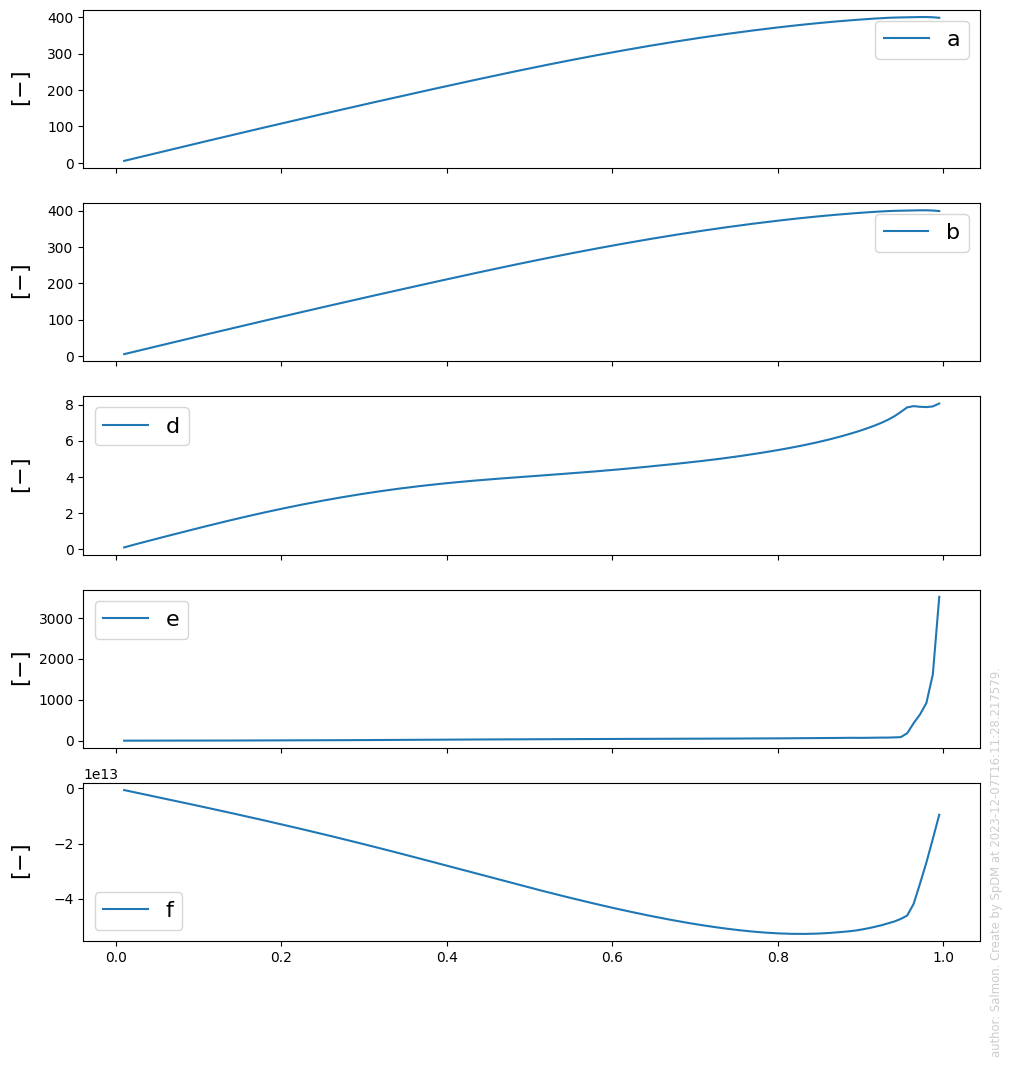

In [8]:
vars = sum([[equ.primary_quantity.profile, equ.primary_quantity.flux] for equ in solver_1d.equation], [])
equ = solver_1d.equation[2]
(u0, v0, w0), (u1, v1, w1), a, b, c, d, e, f, g = equ.coefficient
x = solver_1d.grid.rho_tor_norm
# y = equ.primary_quantity.profile
# yp = equ.primary_quantity.d_dr
# flux = equ.primary_quantity.flux
# dflux = equ.primary_quantity.dflux_dr
fig = sp_view.plot(
    x,
    (a(x, *vars), "a"),
    (b(x, *vars), "b"),
    # (c(x,*vars), "c"),
    (d(x, *vars), "d"),
    (e(x, *vars), "e"),
    (f(x, *vars), "f"),
    # (g(x, *vars), "g"),
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),
    # ],
    # y, yp
    # [
    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
)

In [9]:
time_slice = tokamak.core_transport.model[1].fetch(**tokamak.transport_solver.variables)

2023-12-07 16:11:29,355 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/core_transport/model/fast_alpha.py:51:fetch: $$\left(\left(\left({0.02} + \left({4.5} \cdot \left(\frac{{T_{e}}}{{3500000.0}}\right)\right)\right) + \left({8.0} \cdot \left(\left(\frac{{T_{e}}}{{3500000.0}}\right) ^ {2}\right)\right)\right) + \left({350} \cdot \left(\left(\frac{{T_{e}}}{{3500000.0}}\right) ^ {3}\right)\right)\right)$$


In [11]:
time_slice.profiles_1d.ion[0].particles.d


d